# Homework 3 - Exercise 1

## Emma Parois

In [1]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

## Load data sets

In [2]:
trainset = torchvision.datasets.MNIST(
    root='../data', 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

In [3]:
testset = torchvision.datasets.MNIST(
    root='../data', 
    train=False, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

In [4]:
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset)-10000, 10000])

In [5]:
batch_size = 8192

In [6]:
train_loader = DataLoader(
    trainset,
    num_workers=2,
    batch_size=batch_size,
    shuffle=True
)

In [7]:
val_loader = DataLoader(
    valset,
    num_workers=2,
    batch_size=len(valset),
    shuffle=True
)
batch_idx, (xVal, yVal) = next(enumerate(val_loader))

In [8]:
test_loader = DataLoader(
    testset,
    num_workers=2,
    batch_size=len(valset),
    shuffle=True
)
batch_idx, (xTest, yTest) = next(enumerate(test_loader))

# Network 1

In [9]:
class Net1(nn.Module):
    
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        self.fc1 = nn.Linear(20 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = x.view(-1, 20 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
net1 = Net1()

In [11]:
epochs = 60

In [12]:
loss_function = nn.CrossEntropyLoss()

In [13]:
optimizer = torch.optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [14]:
val_patience = 5 
val_frequency = 30
f = 0
p = 0
loss_val = []
min_loss = np.inf
loss_epoch = []
loss_val_abscisse = []

In [15]:
%%time
for epoch in tqdm(range(epochs)):
    for batch_idx, (xTrain, yTrain) in enumerate(train_loader):        
        optimizer.zero_grad()
        output = net1(xTrain)
        loss = loss_function(output, yTrain)
        loss.backward()
        optimizer.step()
        
        # Calculate loss validation every val_frequency iterations
        if f%val_frequency == 0:  
            with torch.no_grad():
                output_val = net1(xVal)
                loss_val_item = loss_function(output_val, yVal).item()
              
            loss_val.append(loss_val_item)
            loss_val_abscisse.append(epoch)
                
            if min_loss > min(loss_val):
                min_loss = min(loss_val)
                p = 0
            if loss_val_item >= min_loss:     
                p += 1
            # Check if the validation patience has been reached 
            if p == val_patience:
                break
        f += 1
           
    loss_epoch.append(loss.item())     
    #print('Epoch', epoch, 'training loss', loss.item())

100%|██████████| 60/60 [07:49<00:00,  7.82s/it]

CPU times: user 20min 31s, sys: 7min 7s, total: 27min 38s
Wall time: 7min 49s


### Plot training and validation loss

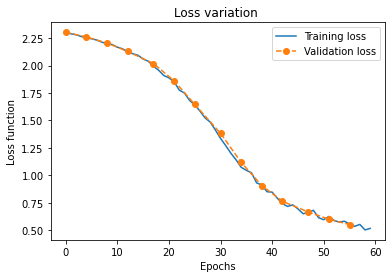

In [16]:
plt.plot(loss_epoch, label="Training loss")
plt.plot(loss_val_abscisse, loss_val, '--o', label="Validation loss")
plt.title("Loss variation ")
plt.ylabel("Loss function")
plt.xlabel("Epochs")
plt.legend(loc="upper right")

## Classification errors

In [17]:
error = lambda y, yTrue: (y != yTrue).sum().true_divide(len(y))

### Classification error for validation set

In [18]:
yVal_pred = net1(xVal).argmax(dim=1)

In [19]:
err_val = error(yVal_pred, yVal)

In [20]:
err_val

tensor(0.1361)

### Classification error for test set

In [21]:
yTest_pred = net1(xTest).argmax(dim=1)

In [22]:
err_test = error(yTest_pred, yTest)

In [23]:
err_test

tensor(0.1283)

# Network 2

In [24]:
class Net2(nn.Module):
    
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, padding=1, stride=1)
        self.batchNorm1 = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        
        self.conv2 = nn.Conv2d(20, 30, kernel_size=3, padding=1, stride=1)
        self.batchNorm2 = nn.BatchNorm2d(30)
        self.pool2 = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        
        self.conv3 = nn.Conv2d(30, 50, kernel_size=3, padding=1, stride=1)
        self.batchNorm3 = nn.BatchNorm2d(50)
        
        self.fc1 = nn.Linear(50 * 7 * 7, 10)
      
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batchNorm1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(self.batchNorm2(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = x.view(-1, 50 * 7 * 7)
        x = self.fc1(x)

        return x

In [25]:
net2 = Net2()

In [26]:
epochs = 30

In [27]:
loss_function = nn.CrossEntropyLoss()

In [28]:
optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

In [29]:
val_patience = 5 
val_frequency = 30
f = 0
p = 0
loss_val = []
min_loss = np.inf
loss_epoch = []
loss_val_abscisse = []

In [30]:
%%time
for epoch in tqdm(range(epochs)):
    for batch_idx, (xTrain, yTrain) in enumerate(train_loader):        
        optimizer2.zero_grad()
        output = net2(xTrain)
        loss = loss_function(output, yTrain)
        loss.backward()
        optimizer2.step()
        
        # Calculate loss validation every val_frequency iterations
        if f%val_frequency == 0:  
            with torch.no_grad():
                output_val = net2(xVal)
                loss_val_item = loss_function(output_val, yVal).item()
              
            loss_val.append(loss_val_item)
            loss_val_abscisse.append(epoch)
                
            if min_loss > min(loss_val):
                min_loss = min(loss_val)
                p = 0
            if loss_val_item >= min_loss:     
                p += 1
            # Check if the validation patience has been reached 
            if p == val_patience:
                break
        f += 1
            
    loss_epoch.append(loss.item())     
    #print('Epoch', epoch, 'training loss', loss.item())

100%|██████████| 30/30 [08:26<00:00, 16.90s/it]

CPU times: user 23min 54s, sys: 7min 30s, total: 31min 24s
Wall time: 8min 26s


### Plot training and validation loss

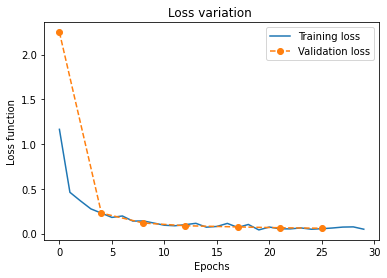

In [31]:
plt.plot(loss_epoch, label="Training loss")
plt.plot(loss_val_abscisse, loss_val, '--o', label="Validation loss")
plt.title("Loss variation ")
plt.ylabel("Loss function")
plt.xlabel("Epochs")
plt.legend(loc="upper right")

## Classification errors

### Classification error for validation set

In [32]:
yVal_pred = net2(xVal).argmax(dim=1)

In [33]:
err_val = error(yVal_pred, yVal)

In [34]:
err_val

tensor(0.0160)

### Classification error for test set

In [35]:
yTest_pred = net2(xTest).argmax(dim=1)

In [36]:
err_test = error(yTest_pred, yTest)

In [37]:
err_test

tensor(0.0160)